This notebook is based on the [Fast.ai](www.fast.ai) MOOC's lectures and the techniques covered in the course. 
I am using the dataset available at Kaggle.com for [plant-seedlings-classification](https://www.kaggle.com/c/plant-seedlings-classification). 
I will also be including some tips from Prof Andrew NG's [deeplearning.ai](https://www.coursera.org/specializations/deep-learning) course in coursera

**I have limited GPU resources, therefore i will be using transfer learning**. But there are other [Kernels](https://www.kaggle.com/c/plant-seedlings-classification/kernels) in kaggle where users built CNN's from scratch.

# 1. Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib.image as mpimg

import os

import plotly.tools as tls
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# 2. Data I/O and EDA

In [2]:
submission=pd.read_csv('sample_submission.csv')

In [3]:
submission.head()

file     species
0  0021e90e4.png  Sugar beet
1  003d61042.png  Sugar beet
2  007b3da8b.png  Sugar beet
3  0086a6340.png  Sugar beet
4  00c47e980.png  Sugar beet

**The submission.csv file should be used for the uploading the results into Kaggle for score**

In [4]:
!ls

labels.csv	       seed-classification-challenge-fastai.ipynb  test  train
sample_submission.csv  submission.csv				   tmp


In [5]:
!ls train/

Black-grass  Common-Chickweed  Loose-Silky-bent   Shepherds-Purse
Charlock     Common-wheat      Maize		  Small-flowered-Cranesbill
Cleavers     Fat-Hen	       Scentless-Mayweed  Sugar-beet


### Inference:
* This is a **Multi-Class Classification** problem and the plant seedling varieties are named on the folders with the images for each of them inside respective folders
* The navigation to the images has to be provided into a csv file with the labels
* For the easier navigation **lables.csv** is created using the code below, initially it was not present**.  This csv file will help the fast.ai library navigate the images in different folders easily

**Note: The folder structure is not exactly in the format mentioned in fast.ai course for image classification tasks. Here there is also no validation folder.**

In [6]:
seed_var=os.listdir('train/')

In [7]:
seed_df=pd.DataFrame(columns=['file','species'])

In [8]:
files=[]
species=[]
for i in range(len(seed_var)):
    s_files=os.listdir('train/'+seed_var[i])
    for j in range(len(s_files)):
        files.append(seed_var[i]+'/'+s_files[j])
        species.append(seed_var[i])

In [9]:
print('The total number of Plant-seedling images: '+str(len(species)))

The total number of Plant-seedling images: 4750


** Not so many images. The best practice is to use transfer learning**

In [10]:
seed_df['file']=files
seed_df['species']=species

In [11]:
seed_df.head()

file                    species
0  Small-flowered-Cranesbill/8023cf2e2.png  Small-flowered-Cranesbill
1  Small-flowered-Cranesbill/e02e72548.png  Small-flowered-Cranesbill
2  Small-flowered-Cranesbill/e682d2f54.png  Small-flowered-Cranesbill
3  Small-flowered-Cranesbill/643b99d1d.png  Small-flowered-Cranesbill
4  Small-flowered-Cranesbill/4f0970770.png  Small-flowered-Cranesbill

In [12]:
seed_df=seed_df.sample(frac=1).reset_index(drop=True)

In [13]:
seed_df.to_csv('labels.csv',index=False)

In [14]:
seed_df.head()

file           species
0  Common-Chickweed/0907487ed.png  Common-Chickweed
1  Common-Chickweed/593e2f0e9.png  Common-Chickweed
2  Loose-Silky-bent/d734ed06a.png  Loose-Silky-bent
3             Maize/61c7d55b0.png             Maize
4           Fat-Hen/dbb008ffc.png           Fat-Hen

**Created the labels.csv file which has image-file locations and the labels for each file**

In [15]:
#plt.style.use('ggplot')
#plt.figure(figsize=(15,8))
#sns.countplot(x='species',data=seed_df)
species=seed_df['species'].value_counts()
trace=go.Bar(x=species.index.tolist(),y=species.values,marker=dict(color=species.values))

layout=go.Layout(title= 'Plant Seedlings Frequency in the dataset')
fig=go.Figure(data=[trace],layout=layout)
py.iplot(fig)

In [16]:
unique_species=seed_df['species'].unique().tolist()

In [17]:
# Plot initials and evolutions
def plot_species(usp):
    f, axarr = plt.subplots(1, 3)
    plt.subplots_adjust(left=0.0, bottom=0, right=2.0, top=5.0,wspace=0.1, hspace=0.25)
    tmp=seed_df[seed_df['species']==usp]
    tmp=tmp.head(3)
    tmp=tmp['file'].values.tolist()
    img1=mpimg.imread('train/'+'/'+tmp[0])
    axarr[0].imshow(img1)
    axarr[0].set_title(usp+'-img-1')
    img2=mpimg.imread('train/'+'/'+tmp[1])
    axarr[1].imshow(img2)
    axarr[1].set_title(usp+'-img-2')
    img3=mpimg.imread('train/'+'/'+tmp[2])
    axarr[2].imshow(img3)
    axarr[2].set_title(usp+'-img-3')

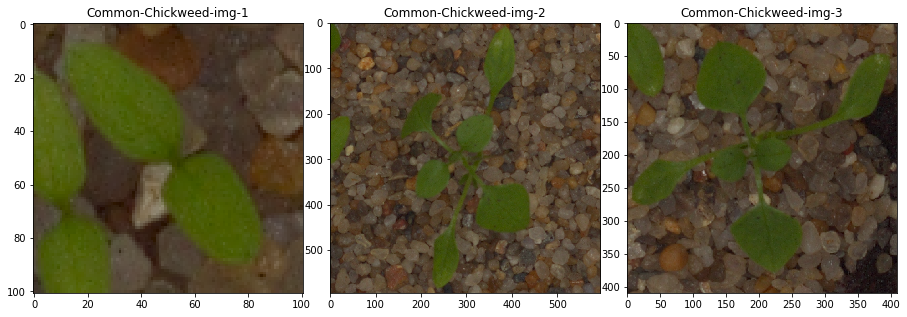

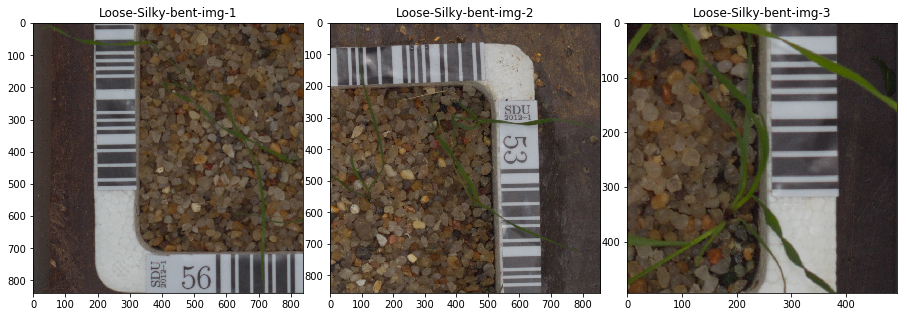

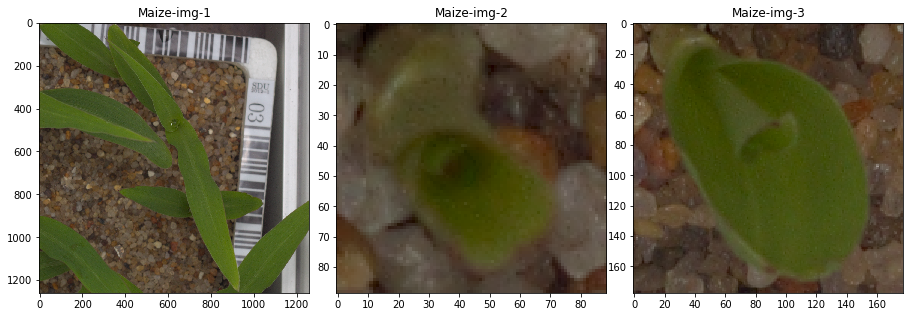

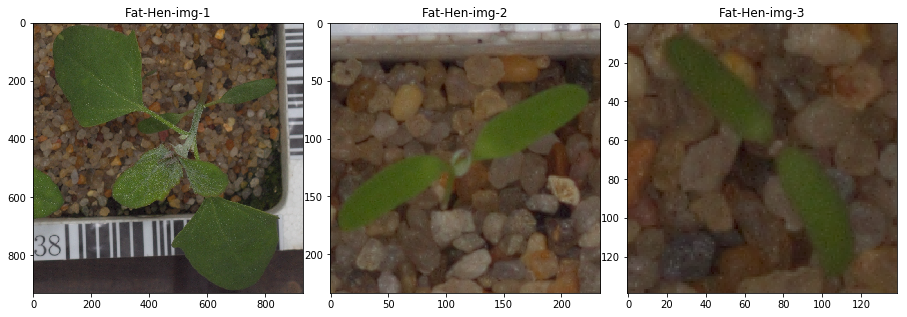

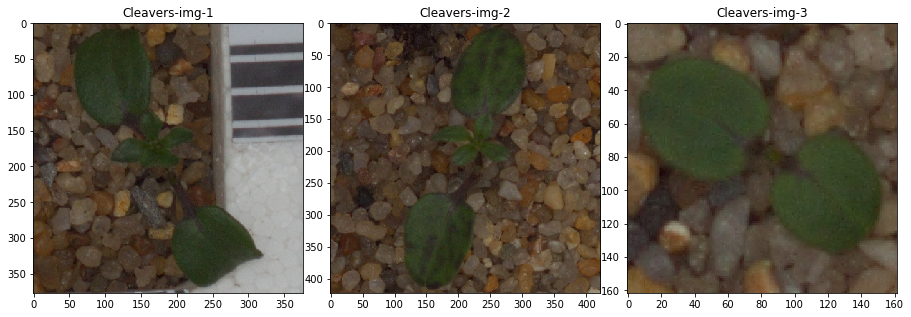

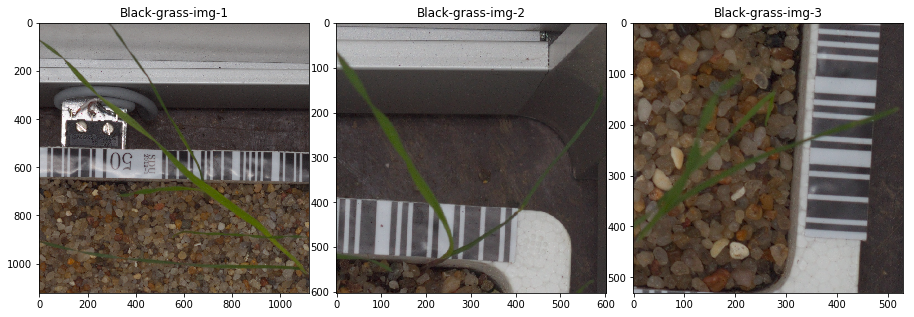

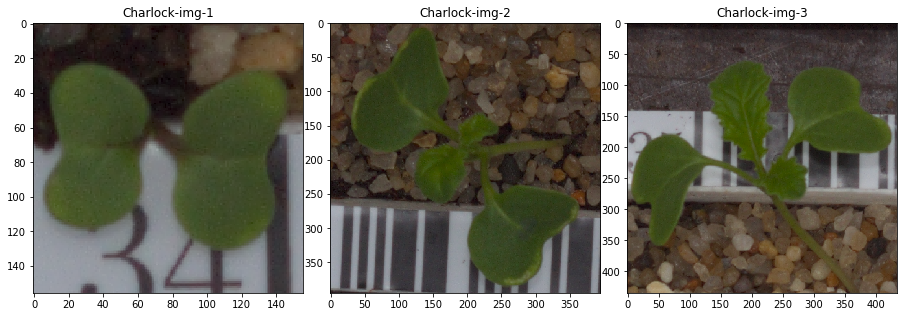

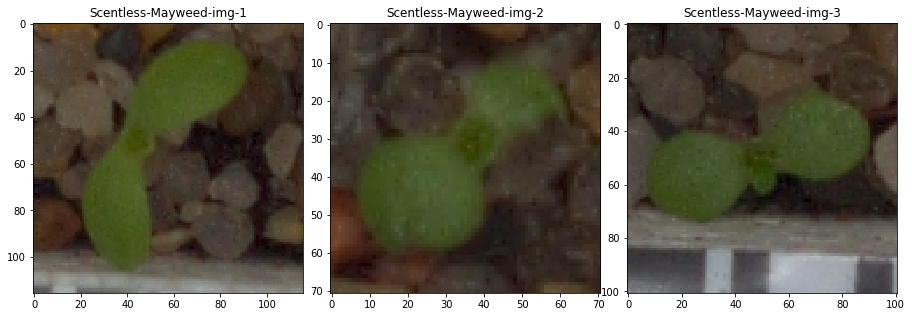

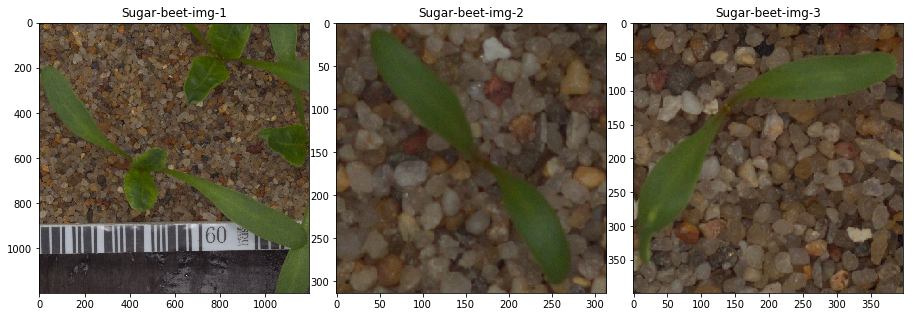

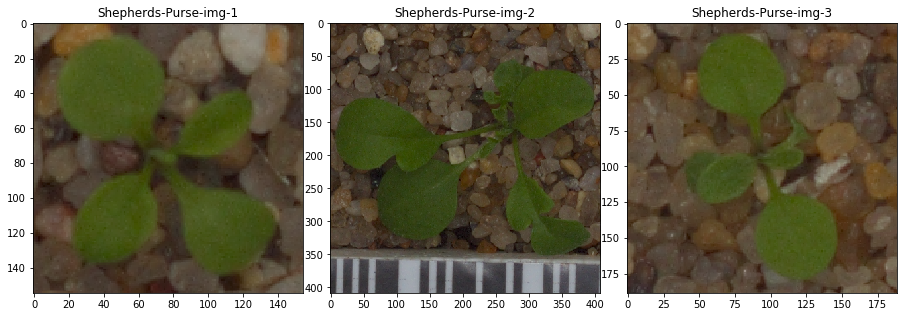

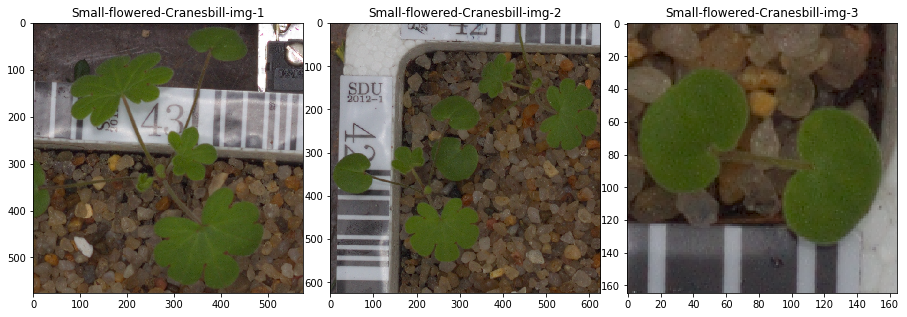

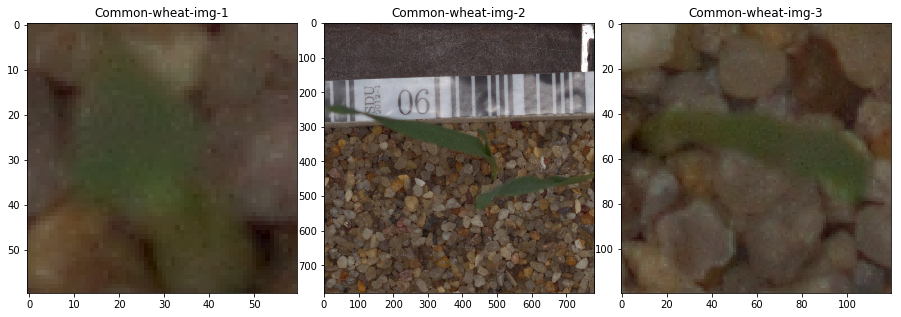

In [18]:
for i in range(len(unique_species)):
    plot_species(unique_species[i])

### Inference: 
* From the Images of different plant-seedlings it can be observed that there are stones in the background
* Some of the images are blurry may be because when plotting they are resized (should check the image sizes)
* Blackgrass and Loose silky bent are almost similar in the images

# 3. Fast.ai Training approach

In [19]:
# Now Training using fastai approach for multi-class classification

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.model import *
from fastai.sgdr import *

**Checking Torch and Cuda are enabled to train on GPU**

In [22]:
torch.cuda.is_available()

True

In [23]:
torch.backends.cudnn.enabled

True

### Parameters to set: 
* Learning Rate has to be decided
* Image size has to be fixed
* Architecture has to be decided
* Batch Size

**Initially I use:** Image size =224 and ResNet34 trained on Image Net and batch size of 32 and learning rate = 1e-2

**These parameters will investigated and fixed upon training and error analysis**

In [24]:
PATH=os.getcwd()+'/'

# The parameter sz= size of the image after rescaling from the original image
sz=224
# The arch= The network architecture used for training (Here it is ResNet34)  
arch=resnet34
# The parameter bs = Mini batchsize for training (from andrew ng's course it is generally chosen to be power of 2)
bs=32 # I chose 2^5 =32 as my mini-batch size

### Validation set:
* Since there is not validation set of images I have to select them myself. therefore i used the labels.csv file to create validation indexes which the training algorithm will use for validation
* Random 20% of the total images is the validation set 

In [25]:
labels_csv=f'{PATH}labels.csv'
n=len(list(open(labels_csv)))-1
val_idxs=get_cv_idxs(n)

In [26]:
len(val_idxs) # 20% of total training set 

950

### Parameter Check-1:
* First the general size distribution of the images have to be checked
* Confirming if 224 is a reasonable size to rescale

In [27]:
tfms=tfms_from_model(arch,sz,aug_tfms=transforms_top_down,max_zoom=1.1)
data=ImageClassifierData.from_csv(PATH,'train',f'{PATH}labels.csv',test_name='test',
                                val_idxs=val_idxs,tfms=tfms,bs=bs)

In [28]:
fn=PATH+data.trn_ds.fnames[0];
fn

'/home/harisyam_bphc/.kaggle/competitions/plant-seedlings-classification/train/Black-grass/0050f38b3.png'

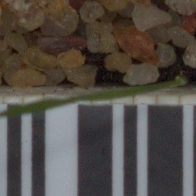

In [29]:
img = PIL.Image.open(fn);img

In [30]:
img.size

(196, 196)

In [31]:
size_d={k:PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz,col_sz=list(zip(*size_d.values()))

row_sz=np.array(row_sz)
col_sz=np.array(col_sz)

(array([2149., 1133.,  318.,  133.,   43.,    9.,    9.,    3.,    0.,    3.]),
 array([  49.,  357.,  665.,  973., 1281., 1589., 1897., 2205., 2513., 2821., 3129.]),
 <a list of 10 Patch objects>)

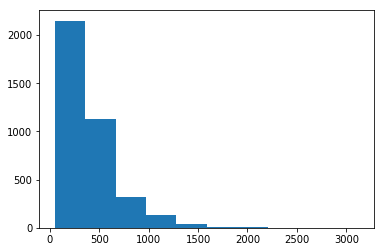

In [32]:
plt.hist(row_sz)

(array([2148., 1125.,  329.,  131.,   43.,   10.,   12.,    1.,    0.,    1.]),
 array([  49.,  357.,  665.,  973., 1281., 1589., 1897., 2205., 2513., 2821., 3129.]),
 <a list of 10 Patch objects>)

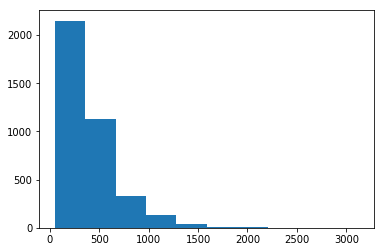

In [33]:
plt.hist(col_sz)

In [34]:
# Using plotly's Box plot will be more intutive to determine the size stats
size_df=pd.DataFrame(columns=['row_sz','col_sz'])
size_df['row_sz']=row_sz
size_df['col_sz']=col_sz
size_df.head()

row_sz  col_sz
0     196     196
1     388     388
2     886     886
3     117     117
4     471     471

In [35]:
trace1=go.Box(y=size_df['row_sz'].values,name='Img Width')
trace2=go.Box(y=size_df['col_sz'].values,name='Img Height')

trace=[trace1,trace2]
layout=go.Layout(title= 'Plant Seedlings Image height and width distribution')
fig=go.Figure(data=trace,layout=layout)
py.iplot(fig)

### Inference:
* The Row size distribution suggests that the most of the images lie in 0 to 500px range
* The col size distribution suggest the same as the row distirbution
* There are some very big images and there are some small images
* The median size is 270x270 pixels
* 224 our initial batch size is lower than the median
* The best range to cover all the images is to be aroud 300px (from mean value)

**Note: Initially the training will be carried out with 224 and then i will change the image size**

## 3.1 Baseline Model -- ResNet 34 Arch

In [36]:
#Initial model

In [37]:
def get_data(sz,bs):
    tfms=tfms_from_model(arch,sz,aug_tfms=transforms_top_down,max_zoom=1.1)
    data=ImageClassifierData.from_csv(PATH,'train',f'{PATH}labels.csv',test_name='test',
                                     val_idxs=val_idxs,tfms=tfms,bs=bs)
    return data if sz > 300 else data.resize(340,'tmp')

In [36]:
data=get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [38]:
learn=ConvLearner.pretrained(arch,data,precompute=True)
learn.fit(1e-2,3)

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning:

nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/119 [00:00<?, ?it/s]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      1.26916 0.75269 0.73674]                                                      
[1.      0.94571 0.63482 0.7821 ]                                                      
[2.      0.78717 0.58979 0.78362]                                                     



### Observation:
* After training 3 epochs for the pre-trained resnet34 model the training accuracy is 80%
* The training loss > validation loss --> Underfitting problem
**Dealing with underfitting problem:**
* Run the training for some more epochs
* Check the optimal learning rate
* Use a bigger architecture

In [39]:
#run more epcohs
learn.fit(1e-2,10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  4%|▍         | 5/119 [00:00<00:05, 19.45it/s, loss=tensor(0.6768, device='cuda:0')]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      0.74211 0.55445 0.81487]                                                      
[1.      0.68391 0.52975 0.82112]                                                      
[2.      0.61795 0.49385 0.8357 ]                                                      
[3.      0.56962 0.47689 0.83362]                                                      
[4.      0.52081 0.47627 0.83258]                                                      
[5.      0.5149  0.46204 0.83778]                                                      
[6.      0.47899 0.462   0.82424]                                                      
[7.      0.45131 0.44289 0.85237]                                                      
[8.      0.41232 0.42369 0.85388]                                                      
[9.      0.43259 0.42163 0.85388]                                                      



### Observation:
* Training more epochs did bring the training and validation loss closer and  are lesser compared to the the previous run
* The accuracy changed to 83% --> But it could still be improved

In [40]:
# Adjusting the learning rate
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  4%|▍         | 5/119 [00:00<00:06, 18.35it/s, loss=tensor(0.2795, device='cuda:0')]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



 68%|██████▊   | 81/119 [00:01<00:00, 71.00it/s, loss=tensor(0.7158, device='cuda:0')]


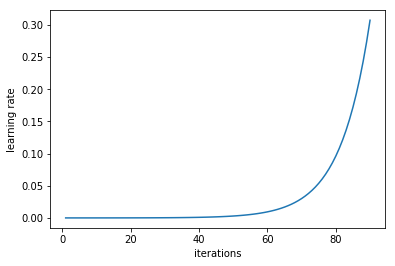

In [41]:
learn.sched.plot_lr()

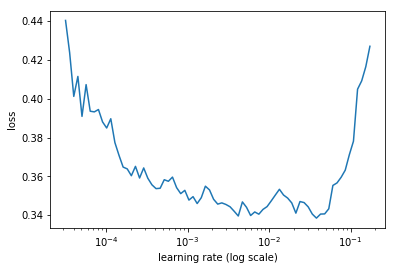

In [42]:
learn.sched.plot()

**The learning rate should be around 5e-3 from the above plot**

**Now Enabling Data Augmentation and using the learning rate from above**

In [41]:
# using lr=5e-3 and precompute = false
learn.precompute=False
learn.fit(5e-3,5,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  1%|          | 1/119 [00:00<01:12,  1.63it/s, loss=tensor(0.5978, device='cuda:0')]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      0.70478 0.41186 0.85492]                                                      
[1.      0.70465 0.39849 0.85805]                                                      
[2.      0.67183 0.40147 0.86373]                                                      
[3.      0.62595 0.40211 0.86326]                                                      
[4.      0.61064 0.37641 0.86638]                                                      



### Observation: 
* The training accuracy impproved a bit with data augmentation
* The training loss is still higher than val loss (underfitting is not removed yet)
* next changing the image size

In [42]:
learn.save('224_pre')

In [43]:
learn.load('224_pre')

In [45]:
learn.set_data(get_data(299,bs)) # what exactly happens here??
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [46]:
learn.fit(5e-3,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/119 [00:00<?, ?it/s]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      0.67079 0.40585 0.85284]                                                      
[1.      0.66016 0.39601 0.85436]                                                      
[2.      0.60021 0.38749 0.85966]                                                      



In [47]:
# here i am underfitting because trn loss > val loss so change the cycle_mult =2

In [48]:
learn.fit(5e-3,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/119 [00:00<?, ?it/s]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      0.61908 0.36956 0.86837]                                                      
[1.      0.61534 0.37565 0.87462]                                                      
[2.      0.58363 0.36901 0.87045]                                                      
[3.      0.56571 0.36897 0.87045]                                                      
[4.      0.57211 0.35866 0.87254]                                                      
[5.      0.52121 0.36004 0.87472]                                                      
[6.      0.5546  0.36372 0.87102]                                                      



### Observation:
* The underfitting problem now clearly shows that we need bigger architecture --> ResNet50
* The Learning rate = 5e-3 and image size = 299 and above is fine
* The cyclic restarts will improve the accuracy a bit more and data augmentation will help

## 3.2 ResNet 50 Arch

In [39]:
sz=299
bs=32
arch=resnet50
data=get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [40]:
learn=ConvLearner.pretrained(arch,data,precompute=True)
learn.fit(5e-3,3)

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning:

nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  5%|▌         | 6/119 [00:00<00:06, 18.56it/s, loss=tensor(2.7725, device='cuda:0')]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      1.0499  0.57557 0.81383]                                                     
[1.      0.65845 0.46113 0.84252]                                                      
[2.      0.47917 0.42566 0.86903]                                                      



In [41]:
#run more epcohs
learn.fit(5e-3,10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  4%|▍         | 5/119 [00:00<00:06, 17.58it/s, loss=tensor(0.4280, device='cuda:0')]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      0.41227 0.37012 0.87008]                                                      
[1.      0.35636 0.37761 0.87216]                                                      
[2.      0.32843 0.34136 0.87528]                                                      
[3.      0.28876 0.33439 0.89138]                                                      
[4.      0.27152 0.32457 0.89763]                                                      
[5.      0.23482 0.29998 0.89451]                                                      
[6.      0.21329 0.3418  0.88883]                                                      
[7.      0.20216 0.30183 0.89555]                                                      
[8.      0.17039 0.30469 0.8893 ]                                                      
[9.      0.1874  0.30066 0.89659]                                                      



In [42]:
# Adjusting the learning rate
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  3%|▎         | 4/119 [00:00<00:07, 14.89it/s, loss=tensor(0.1449, device='cuda:0')]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



 70%|██████▉   | 83/119 [00:01<00:00, 62.46it/s, loss=tensor(0.4984, device='cuda:0')]


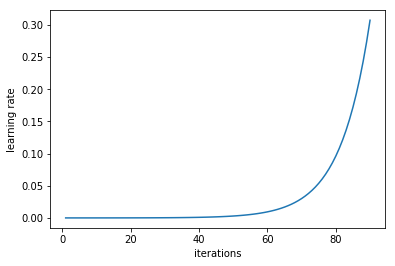

In [43]:
learn.sched.plot_lr()

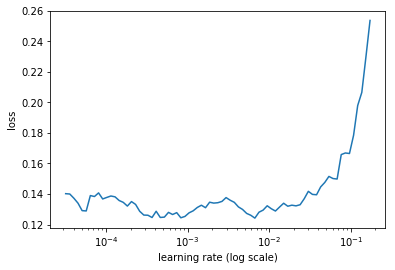

In [44]:
learn.sched.plot()

In [45]:
learn.precompute=False
learn.fit(1e-2,5,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/119 [00:00<?, ?it/s]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      0.49435 0.3033  0.89081]                                                      
[1.      0.49334 0.29648 0.89763]                                                      
[2.      0.46959 0.294   0.88617]                                                      
[3.      0.43806 0.29254 0.88722]                                                      
[4.      0.38129 0.27477 0.89811]                                                      



In [46]:
learn.fit(1e-2,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/119 [00:00<?, ?it/s]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



[0.      0.41726 0.28816 0.89394]                                                      
[1.      0.38393 0.30572 0.88617]                                                      
[2.      0.35917 0.26779 0.89763]                                                      
[3.      0.40068 0.30202 0.88665]                                                      
[4.      0.3756  0.27079 0.90597]                                                      
[5.      0.32446 0.24465 0.9054 ]                                                      
[6.      0.3282  0.24901 0.91013]                                                      



In [47]:
learn.save('299_pre')

In [52]:
learn.load('299_pre')

In [53]:
learn.fit(1e-2,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))


  0%|          | 0/119 [00:00<?, ?it/s]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





 76%|███████▋  | 91/119 [00:44<00:13,  2.06it/s, loss=tensor(0.3106, device='cuda:0')]


100%|██████████| 119/119 [00:57<00:00,  2.07it/s, loss=tensor(0.3419, device='cuda:0')]
                                                                                       [0.      0.34192 0.26414 0.90852]

 52%|█████▏    | 62/119 [00:30<00:27,  2.06it/s, loss=tensor(0.3638, device='cuda:0')]


100%|██████████| 119/119 [00:56<00:00,  2.09it/s, loss=tensor(0.3230, device='cuda:0')]
                                                                                       [1.      0.32302 0.27029 0.90284]

 27%|██▋       | 32/119 [00:16<00:45,  1.92it/s, loss=tensor(0.3055, device='cuda:0')]


100%|██████████| 119/119 [00:57<00:00,  2.07it/s, loss=tensor(0.2929, device='cuda:0')]
                                                                                       [2.      0.29293 0.24582 0.91117]

  3%|▎         | 3/119 [00:01<01:11,  1.62it/s, loss=tensor(0.2932, device='cuda:0')]


 79%|███████▉  | 94/119 [00:45<00:12,  2.06it/s, loss=tensor(0.3328, device='cuda:0')]


100%|██████████| 119/119 [00:57<00:00,  2.07it/s, loss=tensor(0.3546, device='cuda:0')]
                                                                                       [3.      0.35457 0.32348 0.87576]

 55%|█████▍    | 65/119 [00:31<00:26,  2.05it/s, loss=tensor(0.2978, device='cuda:0')]


100%|██████████| 119/119 [00:57<00:00,  2.08it/s, loss=tensor(0.3247, device='cuda:0')]
                                                                                       [4.      0.32473 0.2623  0.89555]

 29%|██▉       | 35/119 [00:18<00:43,  1.93it/s, loss=tensor(0.3258, device='cuda:0')]


100%|██████████| 119/119 [00:57<00:00,  2.07it/s, loss=tensor(0.2934, device='cuda:0')]
                                                                                       [5.      0.29343 0.24522 0.90701]

  5%|▌         | 6/119 [00:03<01:04,  1.76it/s, loss=tensor(0.2922, device='cuda:0')]


 82%|████████▏ | 97/119 [00:47<00:10,  2.06it/s, loss=tensor(0.2862, device='cuda:0')]


100%|██████████| 119/119 [00:57<00:00,  2.07it/s, loss=tensor(0.2761, device='cuda:0')]
                                                                                       [6.      0.27608 0.23622 0.91004]



## Fine-tuning and differential learning rate annealing

In [54]:
learn.unfreeze()

In [55]:
lr=1e-2
lrs=np.array([lr/9,lr/3,lr])

In [56]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))


  0%|          | 0/119 [00:00<?, ?it/s]

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number




 76%|███████▋  | 91/119 [02:08<00:39,  1.42s/it, loss=tensor(0.5275, device='cuda:0')]


100%|██████████| 119/119 [02:48<00:00,  1.41s/it, loss=tensor(0.4469, device='cuda:0')]
                                                                                       [0.      0.44694 0.21377 0.91828]

 52%|█████▏    | 62/119 [01:27<01:20,  1.42s/it, loss=tensor(0.3564, device='cuda:0')]


100%|██████████| 119/119 [02:47<00:00,  1.41s/it, loss=tensor(0.3170, device='cuda:0')]
                                                                                       [1.      0.31702 0.19266 0.92453]

 27%|██▋       | 32/119 [00:47<02:08,  1.47s/it, loss=tensor(0.2631, device='cuda:0')]


100%|██████████| 119/119 [02:48<00:00,  1.41s/it, loss=tensor(0.1776, device='cuda:0')]
                                                                                       [2.      0.1776  0.14611 0.94271]

  3%|▎         | 3/119 [00:04<03:01,  1.57s/it, loss=tensor(0.1768, device='cuda:0')]


 79%|███████▉  | 94/119 [02:12<00:35,  1.41s/it, loss=tensor(0.1858, device='cuda:0')]


100%|██████████| 119/119 [02:47<00:00,  1.41s/it, loss=tensor(0.1817, device='cuda:0')]
                                                                                       [3.      0.18171 0.20893 0.92812]

 55%|█████▍    | 65/119 [01:32<01:16,  1.42s/it, loss=tensor(0.1635, device='cuda:0')]


100%|██████████| 119/119 [02:48<00:00,  1.41s/it, loss=tensor(0.1474, device='cuda:0')]
                                                                                       [4.      0.14743 0.13281 0.95208]

 29%|██▉       | 35/119 [00:51<02:02,  1.46s/it, loss=tensor(0.1245, device='cuda:0')]


 95%|█████████▍| 113/119 [02:39<00:08,  1.41s/it, loss=tensor(0.1001, device='cuda:0')]
 95%|█████████▍| 113/119 [02:40<00:08,  1.42s/it, loss=tensor(1.00000e-02 *
       9.8471, device='cuda:0')]
 96%|█████████▌| 114/119 [02:40<00:07,  1.41s/it, loss=tensor(1.00000e-02 *
       9.8471, device='cuda:0')]
 96%|█████████▌| 114/119 [02:42<00:07,  1.42s/it, loss=tensor(1.00000e-02 *
       9.7404, device='cuda:0')]
 97%|█████████▋| 115/119 [02:42<00:05,  1.41s/it, loss=tensor(1.00000e-02 *
       9.7404, device='cuda:0')]
 97%|█████████▋| 115/119 [02:43<00:05,  1.42s/it, loss=tensor(1.00000e-02 *
       9.6011, device='cuda:0')]
 97%|█████████▋| 116/119 [02:43<00:04,  1.41s/it, loss=tensor(1.00000e-02 *
       9.6011, device='cuda:0')]
 97%|█████████▋| 116/119 [02:45<00:04,  1.42s/it, loss=tensor(1.00000e-02 *
       9.5800, device='cuda:0')]
 98%|█████████▊| 117/119 [02:45<00:02,  1.41s/it, loss=tensor(1.00000e-02 *
       9.5800, device='cuda:0')]
 98%|█████████▊| 117/119 [02:46<00:02,  

       9.5468, device='cuda:0')]
  4%|▍         | 5/119 [00:07<02:53,  1.52s/it, loss=tensor(1.00000e-02 *
       9.5468, device='cuda:0')]
  4%|▍         | 5/119 [00:09<03:25,  1.80s/it, loss=tensor(1.00000e-02 *
       9.7781, device='cuda:0')]
  5%|▌         | 6/119 [00:09<02:49,  1.50s/it, loss=tensor(1.00000e-02 *
       9.7781, device='cuda:0')]
  5%|▌         | 6/119 [00:10<03:16,  1.74s/it, loss=tensor(1.00000e-02 *
       9.6265, device='cuda:0')]
  6%|▌         | 7/119 [00:10<02:47,  1.49s/it, loss=tensor(1.00000e-02 *
       9.6265, device='cuda:0')]
  6%|▌         | 7/119 [00:11<03:09,  1.69s/it, loss=tensor(1.00000e-02 *
       9.6698, device='cuda:0')]
  7%|▋         | 8/119 [00:11<02:44,  1.48s/it, loss=tensor(1.00000e-02 *
       9.6698, device='cuda:0')]
  7%|▋         | 8/119 [00:13<03:03,  1.66s/it, loss=tensor(1.00000e-02 *
       9.6160, device='cuda:0')]
  8%|▊         | 9/119 [00:13<02:42,  1.47s/it, loss=tensor(1.00000e-02 *
       9.6160, device='cuda:0')]
  8%

       8.8999, device='cuda:0')]
 35%|███▌      | 42/119 [00:59<01:49,  1.42s/it, loss=tensor(1.00000e-02 *
       8.8999, device='cuda:0')]
 35%|███▌      | 42/119 [01:01<01:52,  1.46s/it, loss=tensor(1.00000e-02 *
       8.9316, device='cuda:0')]
 36%|███▌      | 43/119 [01:01<01:48,  1.42s/it, loss=tensor(1.00000e-02 *
       8.9316, device='cuda:0')]
 36%|███▌      | 43/119 [01:02<01:50,  1.46s/it, loss=tensor(1.00000e-02 *
       8.8199, device='cuda:0')]
 37%|███▋      | 44/119 [01:02<01:46,  1.42s/it, loss=tensor(1.00000e-02 *
       8.8199, device='cuda:0')]
 37%|███▋      | 44/119 [01:04<01:49,  1.46s/it, loss=tensor(1.00000e-02 *
       8.6737, device='cuda:0')]
 38%|███▊      | 45/119 [01:04<01:45,  1.42s/it, loss=tensor(1.00000e-02 *
       8.6737, device='cuda:0')]
 38%|███▊      | 45/119 [01:05<01:47,  1.45s/it, loss=tensor(1.00000e-02 *
       8.6566, device='cuda:0')]
 39%|███▊      | 46/119 [01:05<01:43,  1.42s/it, loss=tensor(1.00000e-02 *
       8.6566, device='cuda:

       8.3835, device='cuda:0')]
 66%|██████▋   | 79/119 [01:51<00:56,  1.42s/it, loss=tensor(1.00000e-02 *
       8.3835, device='cuda:0')]
 66%|██████▋   | 79/119 [01:53<00:57,  1.44s/it, loss=tensor(1.00000e-02 *
       8.3638, device='cuda:0')]
 67%|██████▋   | 80/119 [01:53<00:55,  1.42s/it, loss=tensor(1.00000e-02 *
       8.3638, device='cuda:0')]
 67%|██████▋   | 80/119 [01:54<00:55,  1.44s/it, loss=tensor(1.00000e-02 *
       8.5363, device='cuda:0')]
 68%|██████▊   | 81/119 [01:54<00:53,  1.42s/it, loss=tensor(1.00000e-02 *
       8.5363, device='cuda:0')]
 68%|██████▊   | 81/119 [01:56<00:54,  1.43s/it, loss=tensor(1.00000e-02 *
       8.4516, device='cuda:0')]
 69%|██████▉   | 82/119 [01:56<00:52,  1.42s/it, loss=tensor(1.00000e-02 *
       8.4516, device='cuda:0')]
 69%|██████▉   | 82/119 [01:57<00:53,  1.43s/it, loss=tensor(1.00000e-02 *
       8.5374, device='cuda:0')]
 70%|██████▉   | 83/119 [01:57<00:51,  1.42s/it, loss=tensor(1.00000e-02 *
       8.5374, device='cuda:

       8.4573, device='cuda:0')]
 97%|█████████▋| 116/119 [02:44<00:04,  1.42s/it, loss=tensor(1.00000e-02 *
       8.4573, device='cuda:0')]
 97%|█████████▋| 116/119 [02:45<00:04,  1.43s/it, loss=tensor(1.00000e-02 *
       8.7526, device='cuda:0')]
 98%|█████████▊| 117/119 [02:45<00:02,  1.42s/it, loss=tensor(1.00000e-02 *
       8.7526, device='cuda:0')]
 98%|█████████▊| 117/119 [02:47<00:02,  1.43s/it, loss=tensor(1.00000e-02 *
       8.7437, device='cuda:0')]
 99%|█████████▉| 118/119 [02:47<00:01,  1.42s/it, loss=tensor(1.00000e-02 *
       8.7437, device='cuda:0')]
 99%|█████████▉| 118/119 [02:48<00:01,  1.42s/it, loss=tensor(1.00000e-02 *
       8.9643, device='cuda:0')]
100%|██████████| 119/119 [02:48<00:00,  1.41s/it, loss=tensor(1.00000e-02 *
       8.9643, device='cuda:0')]
                                                                                                            [6.      0.08964 0.10686 0.96146]



In [57]:
learn.save('299_pre_fine')

# 3.2 using the saved weights

In [58]:
learn=ConvLearner.pretrained(resnet50,data,precompute=False)
learn.load('299_pre_fine')

/home/harisyam_bphc/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning:

nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



In [59]:
log_preds,y=learn.TTA()
probs=np.exp(log_preds)
accuracy(log_preds,y),metrics.log_loss(y,probs)


100%|██████████| 4/4 [00:56<00:00, 14.05s/it]
                                             

(0.9789473684210527, 0.0763870509796139)

# 4. Creating the submission

In [60]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common-Chickweed',
 'Common-wheat',
 'Fat-Hen',
 'Loose-Silky-bent',
 'Maize',
 'Scentless-Mayweed',
 'Shepherds-Purse',
 'Small-flowered-Cranesbill',
 'Sugar-beet']

In [61]:
data.test_ds.fnames

['test/4e18ab737.png',
 'test/721b2c47a.png',
 'test/96ecad7a1.png',
 'test/c64370a72.png',
 'test/7fdb7202d.png',
 'test/599691cd9.png',
 'test/b29339405.png',
 'test/d689256be.png',
 'test/dcd7ff249.png',
 'test/7e9cf1c46.png',
 'test/172f9b10b.png',
 'test/cbe761896.png',
 'test/aaf4da98f.png',
 'test/cb496f36e.png',
 'test/8cfd98117.png',
 'test/699d3c707.png',
 'test/c6c8d4ba0.png',
 'test/664194d19.png',
 'test/80e299ae9.png',
 'test/8db450ce3.png',
 'test/6c874918c.png',
 'test/97b2f0a10.png',
 'test/fef2ade8c.png',
 'test/42e7ed442.png',
 'test/539961189.png',
 'test/36ed4f215.png',
 'test/3edf5e9ef.png',
 'test/d668409ff.png',
 'test/7b21ba6ba.png',
 'test/65e262a6d.png',
 'test/24a058589.png',
 'test/5b3beec58.png',
 'test/486e59179.png',
 'test/502dff972.png',
 'test/0911d3dee.png',
 'test/0ad9e7dfb.png',
 'test/b0acaff4a.png',
 'test/6dd095129.png',
 'test/17529c555.png',
 'test/2dd5cfba9.png',
 'test/a19c3faca.png',
 'test/53e6e9000.png',
 'test/36839d5e9.png',
 'test/f3fc

In [62]:
log_preds,y=learn.TTA(is_test=True)
probs=np.exp(log_preds)


100%|██████████| 4/4 [00:47<00:00, 11.97s/it]
                                             

In [63]:
probs.shape

(794, 12)

In [64]:
preds=np.argmax(probs,axis=1)

In [65]:
submission.head()

file     species
0  0021e90e4.png  Sugar beet
1  003d61042.png  Sugar beet
2  007b3da8b.png  Sugar beet
3  0086a6340.png  Sugar beet
4  00c47e980.png  Sugar beet

In [66]:
df=pd.DataFrame(preds,columns=['species'])
df.insert(0,'file',[o[5:]for o in data.test_ds.fnames])

In [67]:
df.species.unique()

array([ 2,  5, 10, 11,  8,  0,  4,  3,  1,  6,  9,  7])

In [68]:
submission.drop('species',inplace=True,axis=1)
submission=submission.merge(df,on='file',how='left')

In [69]:
submission['species']=submission['species'].map({
    0:'Black-grass',
 1:'Charlock',
 2:'Cleavers',
 3:'Common-Chickweed',
 4:'Common-wheat',
 5:'Fat-Hen',
 6:'Loose-Silky-bent',
 7:'Maize',
 8:'Scentless-Mayweed',
 9:'Shepherds-Purse',
 10:'Small-flowered-Cranesbill',
 11:'Sugar-beet'
})

In [70]:
submission.head()

file                    species
0  0021e90e4.png  Small-flowered-Cranesbill
1  003d61042.png                    Fat-Hen
2  007b3da8b.png                 Sugar-beet
3  0086a6340.png           Common-Chickweed
4  00c47e980.png                 Sugar-beet

In [71]:
submission['species']=submission['species'].map({'Black-grass':'Black-grass',
 'Charlock':'Charlock',
 'Cleavers':'Cleavers',
 'Common-Chickweed':'Common Chickweed',
 'Common-wheat':'Common wheat',
 'Fat-Hen':'Fat Hen',
 'Loose-Silky-bent':'Loose Silky-bent',
 'Maize':'Maize',
 'Scentless-Mayweed':'Scentless Mayweed',
 'Shepherds-Purse':'Shepherds Purse',
 'Small-flowered-Cranesbill':'Small-flowered Cranesbill',
 'Sugar-beet':'Sugar beet'
})

In [72]:
submission.head()

file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet

In [73]:
submission.to_csv('submission_2.csv',index=False)

In [74]:
FileLink(f'submission_2.csv')

/home/harisyam_bphc/.kaggle/competitions/plant-seedlings-classification/submission_2.csv

In [4]:
FileLink(f'seed-classification-challenge-fastai.ipynb')

/home/harisyam_bphc/.kaggle/competitions/plant-seedlings-classification/seed-classification-challenge-fastai.ipynb